In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
# import plotly.express as px
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

In [13]:
img_height = 224
img_width = 224
batch_size = 64

Load the training/validation images

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory("images", 
                                                       labels="inferred",
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size = (img_height,img_width),
                                                       batch_size = batch_size
                                                       )

Found 253 files belonging to 2 classes.
Using 203 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory("images", 
                                                       labels="inferred",
                                                       validation_split=0.2,
                                                       subset="validation",
                                                       seed=123,
                                                       image_size = (img_height,img_width),
                                                       batch_size = batch_size
                                                       )

Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


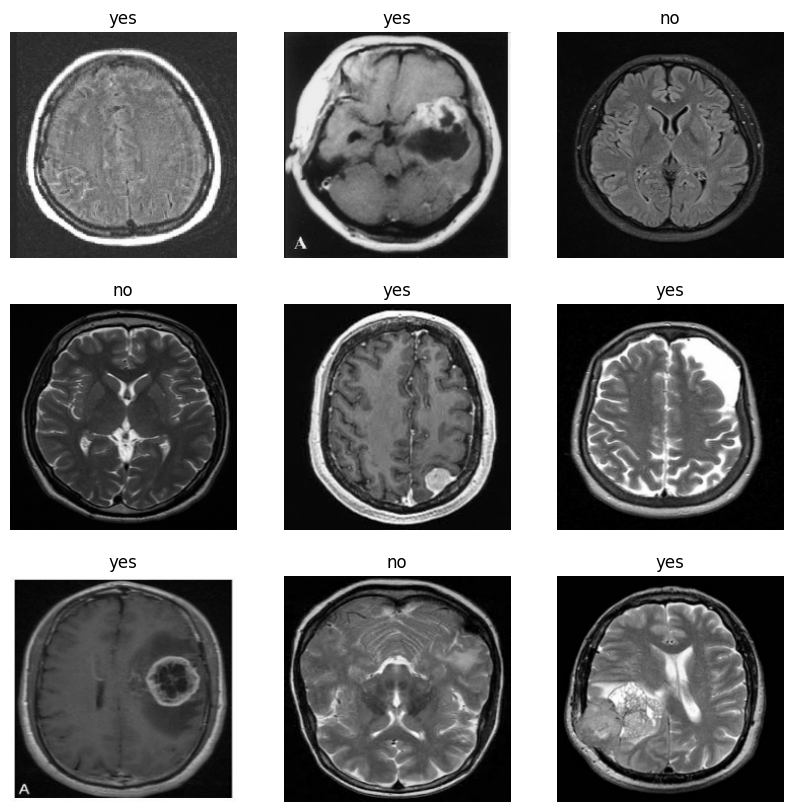

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

NameError: name 'train_dataset' is not defined

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.05,fill_mode="constant",fill_value=0.0),
])

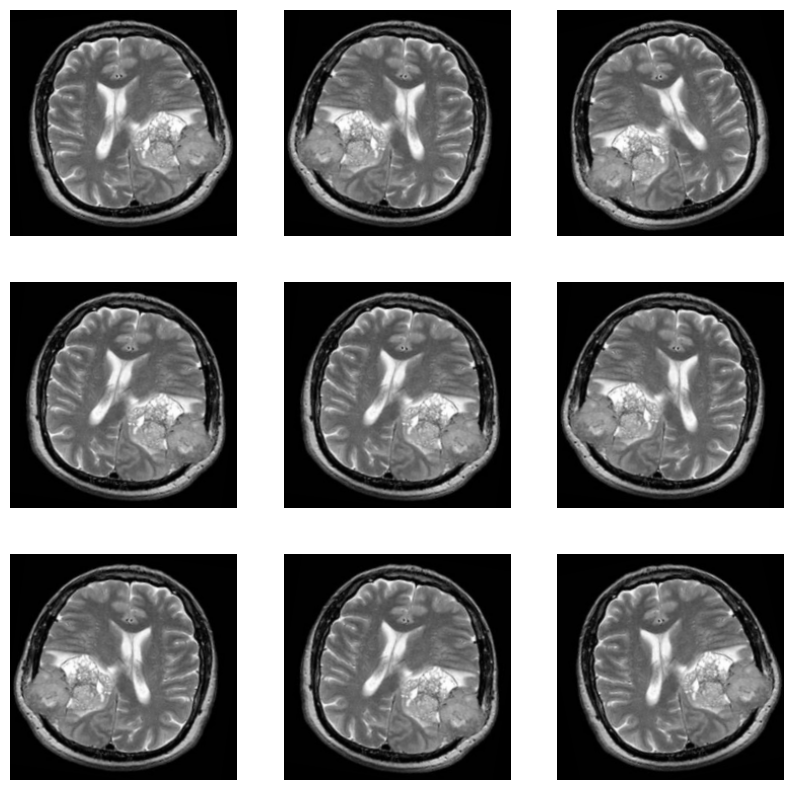

In [28]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#normalization_layer = tf.keras.layers.Rescaling(1./255)
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [32]:
normalized_ds

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>